# Import Dependencies

In [41]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import cluster, metrics
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm

np.random.seed(0)

%matplotlib inline

# Load dataset

<AxesSubplot:xlabel='DeptID', ylabel='Salary'>

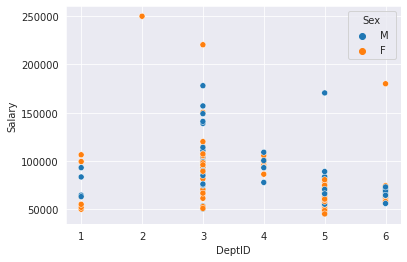

In [42]:
hr_data_set = pd.read_csv('../data/HRDataset_v14.csv', sep=',')
hr_data_set.sample(frac=1, random_state=42).reset_index(drop=True)
hrdataset = hr_data_set

dataNumerical = [
    'DeptID',
    'Salary',
    # 'EngagementSurvey'
]

dataCategorical = [
    # 'Sex',
]

filteredData = hrdataset.copy(deep=True)

importantColumns = dataNumerical + dataCategorical

for c in dataCategorical:
    filteredData[c] = pd.factorize(filteredData[c])[0] + 1

importantData = filteredData[importantColumns]

sns.scatterplot(y='Salary', x='DeptID', data=filteredData, hue='Sex')

I chose other data than in the dimensionality reduction exercise, because the combination of columns from the second exercise doesn’t produce good data to be clustered.

I tried to plot the dept-id in combination with the salary to show if a department earns significantly more money.



# Clustering

In [43]:
importantData

,DeptID,Salary
0,5,62506
1,3,104437
2,5,64955
3,5,64991
4,5,50825
...,...,...
306,5,65893
307,5,48513
308,3,220450
309,3,89292


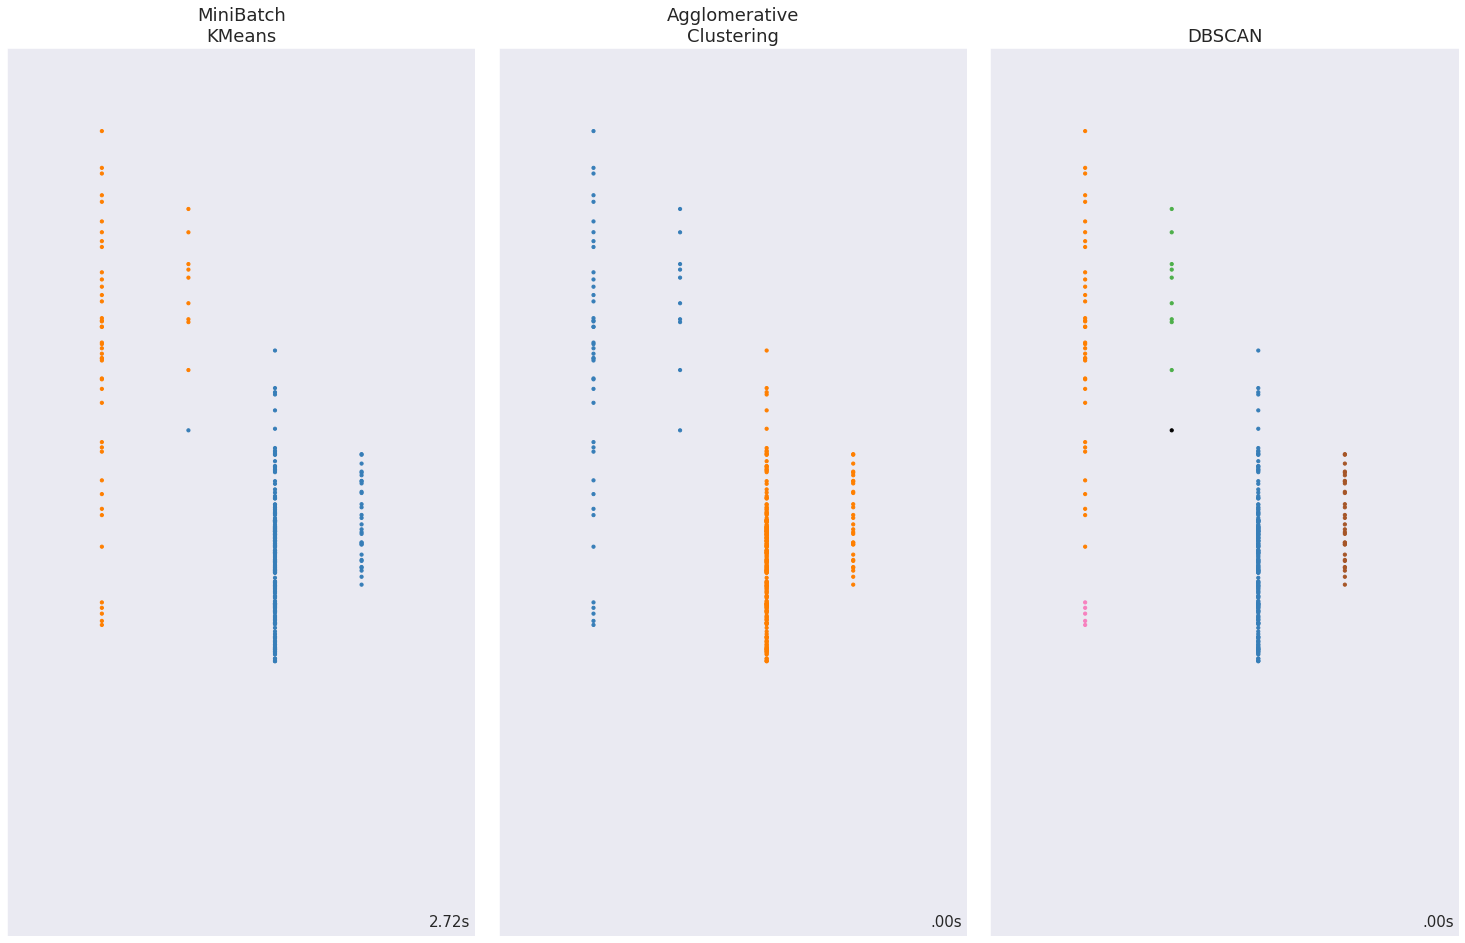

In [44]:
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)
plot_num = 1

default_base = {
    "eps": 0.3,
    "n_clusters": 2,
}

params = default_base.copy()

X = importantData

X = StandardScaler().fit_transform(X)

two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
ward_linkage = cluster.AgglomerativeClustering(
    n_clusters=params["n_clusters"],
)
dbscan = cluster.DBSCAN(eps=params["eps"])

clustering_algorithms = (
    ("MiniBatch\nKMeans", two_means),  # Partitive
    ("Agglomerative\nClustering", ward_linkage),  # Hierarchical
    ("DBSCAN", dbscan),  # Partitive
)

for name, algorithm in clustering_algorithms:
    t0 = time.time()

    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the "
                    + "connectivity matrix is [0-9]{1,2}"
                    + " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning,
        )
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding"
                    + " may not work as expected.",
            category=UserWarning,
        )
        algorithm.fit(X)

    t1 = time.time()
    if hasattr(algorithm, "labels_"):
        y_pred = algorithm.labels_.astype(int)
    else:
        y_pred = algorithm.predict(X)

    plt.subplot(1, len(clustering_algorithms), plot_num)
    plt.title(name, size=18)

    colors = np.array(
        list(
            islice(
                cycle(
                    [
                        "#377eb8",
                        "#ff7f00",
                        "#4daf4a",
                        "#f781bf",
                        "#a65628",
                        "#984ea3",
                        "#999999",
                        "#e41a1c",
                        "#dede00",
                    ]
                ),
                int(max(y_pred) + 1),
            )
        )
    )
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.text(
        0.99,
        0.01,
        ("%.2fs" % (t1 - t0)).lstrip("0"),
        transform=plt.gca().transAxes,
        size=15,
        horizontalalignment="right",
    )
    plot_num += 1

plt.show()

# Results

## k-means and Agglomerative clustering

In the picture below we see the results for 2 clusters, comparing the k-means and agglomerative clustering. The clusters are almost identical for both algorithms.

![hr-cluster-2](./img/hr-c-2.png)

In the picture below we see the results for 4 clusters, comparing the k-means and agglomerative clustering. The results for both algorithms are almost the same. Only the cluster on the left side has points in the middle.

![hr-cluster-4](./img/hr-c-4.png)

In the picture below we have the results for 8 clusters, comparing the k-means and agglomerative clustering. The results for both algorithms are almost the same. Only single points are clustered differently.

![hr-cluster-8](./img/hr-c-8.png)

## DBSCAN

As we see the algorithm produces fewer clusters as the eps value is higher. The eps value is for defining the term dense in the algorithm. Higher values mean that the data must be more dense.

This is the dbscan algorithm for the eps 0.1 value. In this image we see 6 clusters, with the clusters being seperated not very well. One cluster spans over multiple lines.

![hr-eps-0.1](./img/hr-e-0.1.png)

This is the dbscan algorithm for the eps 0.3 value. In this image we see 6 clusters. The clusters are seperated very well over all lines.

![hr-eps-0.3](./img/hr-e-0.3.png)

This is the dbscan algorithm for the eps 0.6 value. The image shows 7 clusters. The clusters are seperated very well over all lines. One cluster includes the points which are distributed over the image.

![hr-eps-0.6](./img/hr-e-0.6.png)



# Comparison

Next we compare the algorithms with the silhouette score. A higher score means that the clusters are better defined.

## Ward Silhouette Score

In [45]:
clusters = [2, 3, 4, 6, 8, 10]

for c in clusters:
    wardLinkage = cluster.AgglomerativeClustering(n_clusters=c)
    clusterLabels = wardLinkage.fit_predict(X)

    silhouetteAvg = metrics.silhouette_score(X, clusterLabels)
    print("For clusters:", c, "The silhouette score is:", silhouetteAvg)


For clusters: 2 The silhouette score is: 0.6990048869567824
For clusters: 3 The silhouette score is: 0.7118739714756549
For clusters: 4 The silhouette score is: 0.7105199193333228
For clusters: 6 The silhouette score is: 0.612354743485339
For clusters: 8 The silhouette score is: 0.5703222051403342
For clusters: 10 The silhouette score is: 0.5790689695184926


First I computed the silhouette score for the agglomerative clustering. I computed the silhouette for 2, 3, 4, 5, 8 and 10 clusters. At first the silhouette score gets better with more clusters, reaching its maximum with 3 and 4 clusters. But the results for 2, 3 and 4 clusters are about the same. Afterwards the results get worse.


## k-Means Silhouette Score

In [46]:
clusters = [2, 3, 4, 6, 8, 10]

for c in clusters:
    two_means = cluster.MiniBatchKMeans(n_clusters=c)
    clusterLabels = two_means.fit_predict(X)

    silhouetteAvg = metrics.silhouette_score(X, clusterLabels)
    print("For clusters:", c, "The silhouette score is:", silhouetteAvg)


For clusters: 2 The silhouette score is: 0.7002792469855791
For clusters: 3 The silhouette score is: 0.7118739714756549
For clusters: 4 The silhouette score is: 0.6986019199970646
For clusters: 6 The silhouette score is: 0.6096755998675248
For clusters: 8 The silhouette score is: 0.564351727295844
For clusters: 10 The silhouette score is: 0.4970050361930092


Next I computed the silhouette score for the k-means clustering. I used the same amount of clusters as for the agglomerative clustering. The result is similar to the agglomerative clustering. But the best result is achieved with 3 clusters. With more clusters the silhouette score gets worse.


## DBSCAN Silhouette Score

In [47]:
eps = [1, 0.6, 0.3, 0.2]

for e in eps:
    dbscan = cluster.DBSCAN(eps=e)
    clusterLabels = dbscan.fit_predict(X)
    _, clusterArray = np.unique(clusterLabels, return_counts=True)
    clusters = len(clusterArray)
    silhouetteAvg = metrics.silhouette_score(X, clusterLabels)
    print("For eps", e, "and clusters:", clusters, "The silhouette score is:", silhouetteAvg, )


For eps 1 and clusters: 3 The silhouette score is: 0.6348498881900254
For eps 0.6 and clusters: 7 The silhouette score is: 0.577214058703922
For eps 0.3 and clusters: 6 The silhouette score is: 0.5517301956270468
For eps 0.2 and clusters: 7 The silhouette score is: 0.5505533272388932


Next I computed the silhouette score for the dbscan algorithm. The algorithm computes the clusters for the data and does not need them as parameter.

But we can get the computed amount of clusters. The results are different from the other two algorithms. Here 3 clusters with eps 1 has the best silhouette score. More clusters have a negative impact on the silhouette score.

DBSCAN looks for clusters of high density. The data is not very dense and clusters distinct data points can be found. But there are not many clusters that can be identified.

We achieve the best score with k-means and agglomerative clustering.

# Davies-Bouldin Index

This index specifies the similarity between clusters. A value that is near 0 means a better partitioning of the clsuters

In [48]:
clusters = [2, 3, 4, 6, 8, 10, 12]

for c in clusters:
    twoMeans = cluster.MiniBatchKMeans(n_clusters=c)
    twoMeansModel = two_means.fit(X)
    twoMeansLabels = twoMeansModel.labels_
    twoMeansScore = metrics.davies_bouldin_score(X, twoMeansLabels)

    print("K-Means: Cluster =", c, "Score =", twoMeansScore)

for c in clusters:
    wardLinkage = cluster.AgglomerativeClustering(n_clusters=c)
    wardLinkageModel = wardLinkage.fit(X)
    wardLinkageLabels = wardLinkageModel.labels_
    wardLinkageScore = metrics.davies_bouldin_score(X, wardLinkageLabels)

    print("Agglomerative Clustering: Cluster =", c, "Score =", wardLinkageScore)

eps = [1, 0.6, 0.3, 0.2]

for e in eps:
    dbscan = cluster.DBSCAN(eps=e)
    dbscanModel = dbscan.fit(X)
    dbscanLabels = dbscanModel.labels_
    dbscanScore = metrics.davies_bouldin_score(X, dbscanLabels)

    print("DBSCAN: EPS =", e, "Score =", dbscanScore)

K-Means: Cluster = 2 Score = 0.5949732809470631
K-Means: Cluster = 3 Score = 0.5555332218245705
K-Means: Cluster = 4 Score = 0.5482194651673813
K-Means: Cluster = 6 Score = 0.6533815192388472
K-Means: Cluster = 8 Score = 0.5017961718587987
K-Means: Cluster = 10 Score = 0.5698125725010734
K-Means: Cluster = 12 Score = 0.6218493816159839
Agglomerative Clustering: Cluster = 2 Score = 0.6515254566168996
Agglomerative Clustering: Cluster = 3 Score = 0.6451987037716876
Agglomerative Clustering: Cluster = 4 Score = 0.6151688423378232
Agglomerative Clustering: Cluster = 6 Score = 0.5661185091159037
Agglomerative Clustering: Cluster = 8 Score = 0.5539046086436601
Agglomerative Clustering: Cluster = 10 Score = 0.5022874805897449
Agglomerative Clustering: Cluster = 12 Score = 0.45371552134104093
DBSCAN: EPS = 1 Score = 0.477043224449327
DBSCAN: EPS = 0.6 Score = 2.362709802355514
DBSCAN: EPS = 0.3 Score = 1.3115144944217494
DBSCAN: EPS = 0.2 Score = 1.5989672011559062


Here i achieved the best result with DBSCAN with an eps value of 1, just like in the large dataset. Agglomerative clustering obtains the best results for 12 clusters, whereas k-means gets the best result with 8 clusters.

Overall all algorithms do not yield a result which is near 0, because the data can't be clustered very well.